In [1]:
%load_ext autoreload
%autoreload 2

# DecisionTree

This notebook presents **a customized implementation of the decision tree** algorithm, allowing users to:

1. Define **their own splitting metric** for node decisions.
2. Enable node splitting based on one or **multiple conditions simultaneously**.

> **Reminder of splitting optimization :**
> 
> Splitting in a decision tree is achieved by **optimizing a metric**. For example, Gini optimization consists in **maximizing** the $\Delta_{Gini}$ :
> 
> *   **The Gini Index** represents the impurity of a group of observations based on the observations of each class (0 and 1):
> 
> $$ I_{Gini} = 1 - p_0^2 - p_1^2 $$
> 
> *   The metric to be maximized is $\Delta_{Gini}$, the difference between **the Gini index on the parent node** and **the weighted average of the Gini index between the two child nodes** ($L$ and $R$).
> 
> $$ \Delta_{Gini} = I_{Gini} - \frac{N_L * I_{Gini_L}}{N} - \frac{N_R * I_{Gini_R}}{N} $$
>
> At each node, the tree algorithm finds the split that minimizes $\Delta$ over all possible splits and over all features. Once the optimal split is selected, the tree is grown by recursively applying this splitting process to the resulting child nodes.

In [2]:
# !pip install pandas

import pandas as pd

from custom_decision_trees import DecisionTree

To illustrate this example, we use data from `titanic.csv`. The goal is to predict the survival of an individual according to various characteristics such as age, sex, etc.

In [3]:
df = (
    pd
    .read_csv("data/titanic.csv")
    [["Survived", "Pclass", "Age", "Fare", "Sex", "Embarked", "SibSp", "Parch"]]
    .dropna()
)

df["Sex"] = df["Sex"].map({"female": 0, "male": 1})
df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})

df.head()

,Survived,Pclass,Age,Fare,Sex,Embarked,SibSp,Parch
0,0,3,22.0,7.2500,1,2,1,0
1,1,1,38.0,71.2833,0,0,1,0
2,1,3,26.0,7.9250,0,2,0,0
3,1,1,35.0,53.1000,0,2,1,0
4,0,3,35.0,8.0500,1,2,0,0


**To define your own splitting metric**, you need to create a class derived from the `custom_tree.metrics.MetricBase` model. This class must contain the same methods and object types as inputs and outputs. 

The `metric_data` parameter refers to the portion of the dataset required to compute the splitting metric. It should be provided as an argument to the `.fit` method when training the model.

> **Note**: the algorithm will always maximize the metric. So if you need minimization, the `.compute_metric` method must return the opposite of the metric.

Here is an example of class for the Gini index :

In [4]:
import numpy as np

from custom_decision_trees.metrics import MetricBase


def compute_gini(
        metric_data: np.ndarray
    ) -> float:

    y = metric_data[:, 0]

    if len(y) == 0:
        return 0.5

    prop0 = np.sum(y == 0) / len(y)
    prop1 = np.sum(y == 1) / len(y)

    metric = 1 - (prop0**2 + prop1**2)

    return float(metric)

class Gini(MetricBase):
    """
    A class that implements the Gini impurity metric for decision trees.
    """

    def __init__(
            self,
        ) -> None:
        pass

    def compute_metric(
            self,
            metric_data: np.ndarray,
            mask: np.ndarray
        ) -> tuple[float, dict]:

        gini_parent = compute_gini(metric_data)
        gini_side1 = compute_gini(metric_data[mask])
        gini_side2 = compute_gini(metric_data[~mask])

        delta = gini_parent - gini_side1 * np.mean(mask) - gini_side2 * (1 - np.mean(mask))

        metadata = {"gini": round(gini_side1, 3)}

        return float(delta), metadata


Next, instantiate the `DecisionTree` by specifying the following parameters:

*   `metric`: an instance of your custom splitting metric class.
*   `nb_max_conditions_per_node`: the maximum number of simultaneous conditions allowed to split a node.
*   Additional standard decision tree parameters (see documentation): `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `n_jobs`.

In [5]:
gini = Gini()

decision_tree = DecisionTree(
    metric=gini,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    nb_max_conditions_per_node=2,
    nb_max_cut_options_per_var=20,
    n_jobs=1
)

Train the model using the `.fit` method.

Here, you must provide the `metric_data` portion of the dataset, which will be passed to the `compute_metric` method defined in your custom metric class.

In [6]:
import warnings

warnings.filterwarnings("error")

features = ["Pclass", "Age", "Fare", "Sex", "Embarked", "SibSp", "Parch"]

X = np.array(df[features])
y = np.array(df["Survived"])
metric_data = np.array(df[["Survived"]])

decision_tree.fit(
    X=X,
    y=y,
    metric_data=metric_data,
)

Print the tree using `.print_tree` to observe the **optimal metric values** at each node, as well as the metadata returned by your custom metric class.

As you can see, the algorithm has optimized the splits based on the custom metric (in this case, the Gini delta). Since `nb_max_conditions_per_node` was set to 2, the model chose to perform splits using up to two variables simultaneously.

In [7]:
decision_tree.print_tree(
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
)

[0] 712 obs -> delta gini = 0.0 | repartition = [424, 288] | {'gini': 0.482}
|   [1] (x["Pclass"] <= 2.0) AND (x["Sex"] <= 0.0) | 157 obs -> delta gini = 0.16 | repartition = [9, 148] | {'gini': 0.108}
|   |   [3] (x["Age"] <= 2.0) AND (x["Pclass"] <= 1.0) | 1 obs -> delta gini = 0.01 | repartition = [1, 0] | {'gini': 0.0}
|   |   [4] (x["Age"] > 2.0) OR (x["Pclass"] > 1.0) | 156 obs -> delta gini = 0.01 | repartition = [8, 148] | {'gini': 0.097}
|   [2] (x["Pclass"] > 2.0) OR (x["Sex"] > 0.0) | 555 obs -> delta gini = 0.16 | repartition = [415, 140] | {'gini': 0.377}
|   |   [5] (x["Age"] <= 8.75) AND (x["SibSp"] <= 2.0) | 27 obs -> delta gini = 0.05 | repartition = [1, 26] | {'gini': 0.071}
|   |   [6] (x["Age"] > 8.75) OR (x["SibSp"] > 2.0) | 528 obs -> delta gini = 0.05 | repartition = [414, 114] | {'gini': 0.339}


For more visual interpretation, you can also obtain a graph with the `.plot_tree` method.

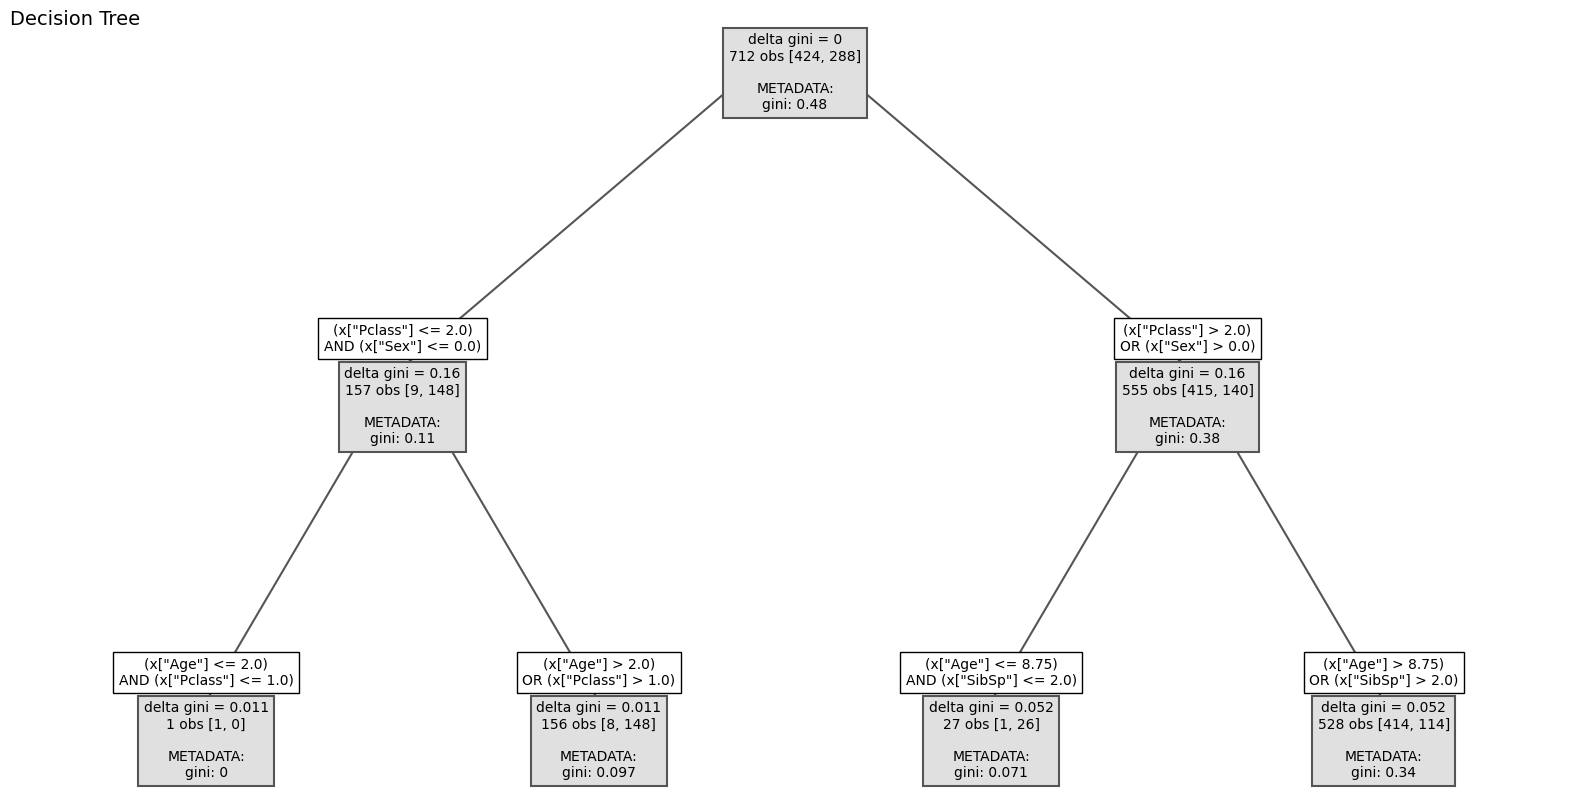

In [8]:
decision_tree.plot_tree(
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
)

Retrieve predicted probabilities with `predict_proba` :

In [9]:
probas = decision_tree.predict_probas(
    X=X
)

probas[:5]

array([[0.78409091, 0.21590909],
       [0.05128205, 0.94871795],
       [0.78409091, 0.21590909],
       [0.05128205, 0.94871795],
       [0.78409091, 0.21590909]])

You can also find predictions of other data such as metrics or metadata.

In [10]:
predictions = decision_tree.predict(
    X=X
)

predictions[:5]

[DecisionTreePrediction(probas=[0.7840909090909091, 0.2159090909090909], metric=0.05165894805534426, metadata={'gini': 0.339}, path=[6, 2, 0]),
 DecisionTreePrediction(probas=[0.05128205128205128, 0.9487179487179487], metric=0.011392775074871755, metadata={'gini': 0.097}, path=[4, 1, 0]),
 DecisionTreePrediction(probas=[0.7840909090909091, 0.2159090909090909], metric=0.05165894805534426, metadata={'gini': 0.339}, path=[6, 2, 0]),
 DecisionTreePrediction(probas=[0.05128205128205128, 0.9487179487179487], metric=0.011392775074871755, metadata={'gini': 0.097}, path=[4, 1, 0]),
 DecisionTreePrediction(probas=[0.7840909090909091, 0.2159090909090909], metric=0.05165894805534426, metadata={'gini': 0.339}, path=[6, 2, 0])]

## Additional features

### Highlight the prediction of an observation in the decision tree visualization.

The `x_to_predict` parameter in the `.print_tree` and `plot_tree` methods is used to specify an observation whose prediction will be highlighted in the visualization. This allows you to understand the choices made by the algorithm.

In the `.print_tree` method, this displays in bold the nodes through which the observation passes :

In [11]:
decision_tree.print_tree(
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
    x_to_predict=X[0, :]
)

[0] 712 obs -> delta gini = 0.0 | repartition = [424, 288] | {'gini': 0.482}
|   [1] (x["Pclass"] <= 2.0) AND (x["Sex"] <= 0.0) | 157 obs -> delta gini = 0.16 | repartition = [9, 148] | {'gini': 0.108}
|   |   [3] (x["Age"] <= 2.0) AND (x["Pclass"] <= 1.0) | 1 obs -> delta gini = 0.01 | repartition = [1, 0] | {'gini': 0.0}
|   |   [4] (x["Age"] > 2.0) OR (x["Pclass"] > 1.0) | 156 obs -> delta gini = 0.01 | repartition = [8, 148] | {'gini': 0.097}
|   [2] (x["Pclass"] > 2.0) OR (x["Sex"] > 0.0) | 555 obs -> delta gini = 0.16 | repartition = [415, 140] | {'gini': 0.377}
|   |   [5] (x["Age"] <= 8.75) AND (x["SibSp"] <= 2.0) | 27 obs -> delta gini = 0.05 | repartition = [1, 26] | {'gini': 0.071}
|   |   [6] (x["Age"] > 8.75) OR (x["SibSp"] > 2.0) | 528 obs -> delta gini = 0.05 | repartition = [414, 114] | {'gini': 0.339}
Prediction : probas=[0.78, 0.22] ; metric=0.05


In the `.plot_tree` method, this enlarges the contour of the nodes through which the observation passes :

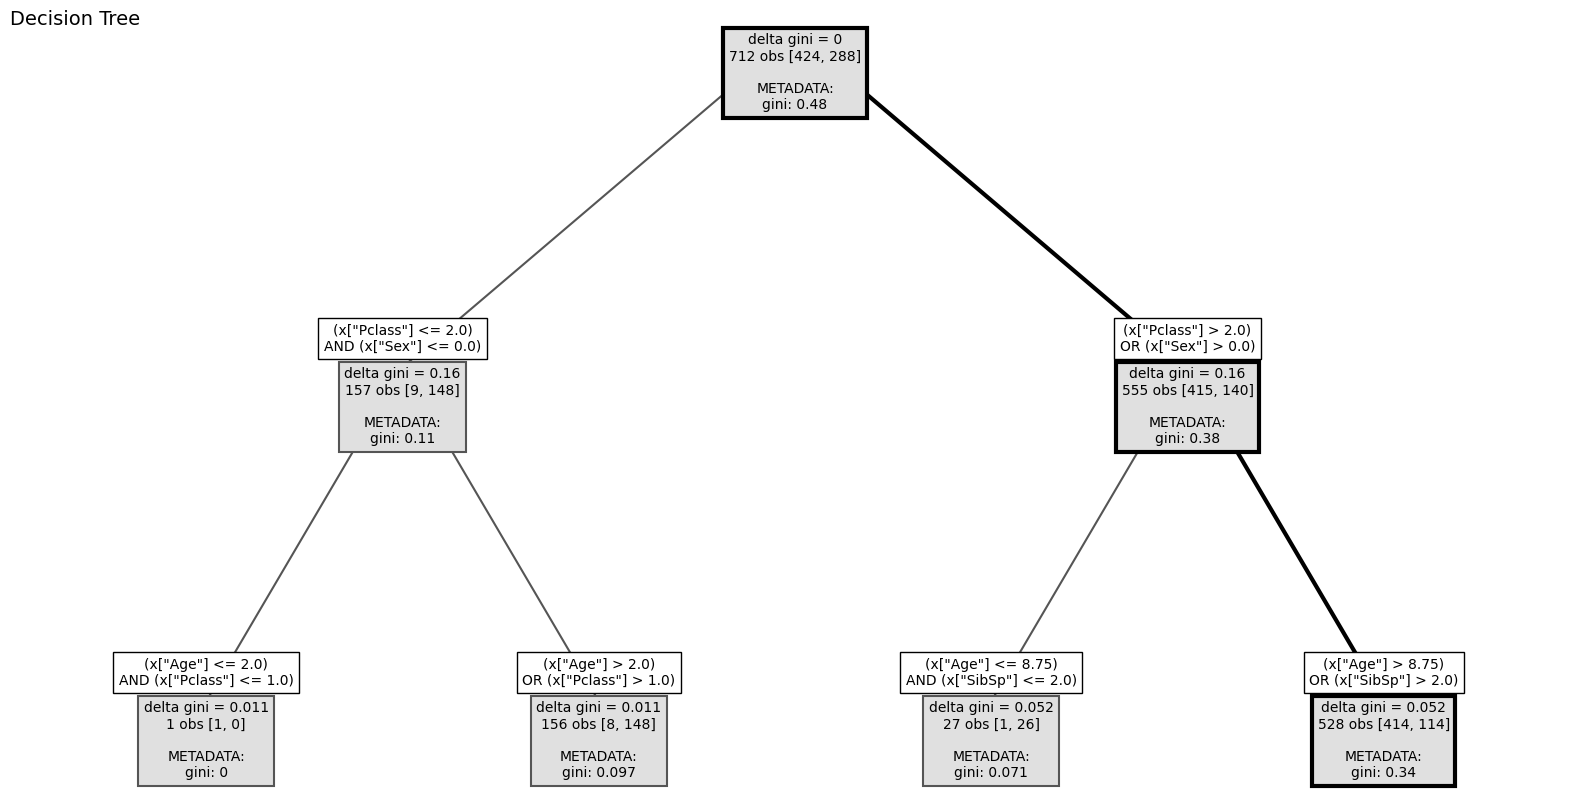

In [12]:
decision_tree.plot_tree(
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
    x_to_predict=X[0, :]
)